# Pairwise Alert similarity 
Analysis to evaluate pairwise alert similarity using OECD Protein binding and DNA binding alerts.
- Prepared by: Grace Patlewicz
- Update 16th May 2025 to change incorrect axis labels on boxplot

In [1]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import networkx as nx

In [4]:
protein = pd.read_excel(external_dir/'Enoch_CRT.xlsx')

In [19]:
def tweak_protein(df):
    return (df
        .rename(columns={'SMARTS Pattern': 'smarts', 'Alert name': 'alert_name', 'Alert Class': 'alert_class'})
        .assign(smarts = lambda df: df['smarts'].apply(lambda x: x.lstrip().rstrip()))
        .assign(alert_name = lambda df: df['alert_name'].apply(lambda x: x.lstrip().rstrip()))
        .assign(alert_class=lambda df: df.apply(
            lambda row: 'Other' if row['alert_name'] in ['Isothiocyanates', 'Carbodiimides', 'Dithiocarbonimidic acid esters', 'Ketenes'] else row['alert_class'], axis=1))
        .assign(section=lambda df: df.apply(
            lambda row: 2.3 if row['alert_name'] in ['Isothiocyanates', 'Carbodiimides', 'Dithiocarbonimidic acid esters', 'Ketenes'] else row['Section'], axis=1))
        .assign(section=lambda df: df['section'].ffill())
        .assign(alert_class=lambda df: df['alert_class'].ffill())
             .assign(Alert=lambda df: 'Pr' + '_' + df['Alert'] )
        .loc[:, ['alert_name', 'alert_class', 'section', 'Alert', 'Mech', 'smarts']]
           
    )
          

In [20]:
protein = tweak_protein(protein)

In [21]:
alert_dict = {k:v['alert_name'] for k, v in protein.groupby('alert_class')}

In [22]:
alert_dict.keys()

dict_keys(['Acid imides', 'Activated six membered (hetero)aromatic ring systems', 'Acyclic carbonyls', 'Chemicals activated to an episulfonium ion', 'Chemicals with a reactive halogen atom', 'Chemicals with a reactive nitrogen atom', 'Chemicals with a reactive sp2 carbon atom', 'Chemicals with a reactive sp3 carbon atom', 'Chemicals with a reactive sulphur atom', 'Di-carbonyls', 'Formaldehyde releasers', 'Mono-carbonyls', 'Other', 'Polarised alkenes and related nitrogen chemicals', 'Polarised alkynes', 'Quinones and related chemicals', 'Strained ring systems'])

In [23]:
protein.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alert_name   104 non-null    object 
 1   alert_class  104 non-null    object 
 2   section      104 non-null    float64
 3   Alert        104 non-null    object 
 4   Mech         104 non-null    object 
 5   smarts       104 non-null    object 
dtypes: float64(1), object(5)
memory usage: 5.0+ KB


In [24]:
protein

,alert_name,alert_class,section,Alert,Mech,smarts
0,Acyl halides,Acyclic carbonyls,2.1,Pr_AC-01,Acyl,"[#6,#1]C(=O)[F,Cl,Br,I]"
1,Acetates,Acyclic carbonyls,2.1,Pr_AC-02,Acyl,"[#6,#1]C(=[O,SX2])[O,SX2,NX3][$([a;r6]),$([a;r..."
2,Acyclic anhydrides,Acyclic carbonyls,2.1,Pr_AC-03,Acyl,"[#6][C;!R](=O)[$([O,S]([C;!R](=O)[#6])C(=O)[#6])]"
3,Dialkyl carbamoylhalides,Acyclic carbonyls,2.1,Pr_AC-04,Acyl,"N([#6])([#6])C(=O)[F,Cl,Br,I]"
4,Sulphonyl halides,Acyclic carbonyls,2.1,Pr_AC-05,Acyl,"[#6,#1]S(=O)(=O)[F,Cl,Br,I,$(C#N)]"
...,...,...,...,...,...,...
99,Polarised alkenes with an alkyl (thio)phosphon...,Chemicals with a reactive sp2 carbon atom,5.6,Pr_SN2-37,SN2,"C=[CH]OP(=[O,SX])(O[#6])[#6]"
100,Polarised alkenes with an alkyl (thio)phosphat...,Chemicals with a reactive sp2 carbon atom,5.6,Pr_SN2-38,SN2,"C=[CH]OP(=[O,SX])(O[#6])O[#6]"
101,Mustards,Chemicals activated to an episulfonium ion,5.7,Pr_SN2-39,SN2,"[NX3,SX2][CH2,$([CH]([NX3,SX2])([CX4])[CX4])][..."
102,"1,2-Dihaloalkanes",Chemicals activated to an episulfonium ion,5.7,Pr_SN2-40,SN2,"[Cl,Br,I][CH2,$([CH]([Cl,Br,I])([CX4])[CX4])][..."


In [25]:
protein_alert_map = {k:v for k,v in zip(protein['Alert'], protein['alert_name'])}

In [26]:
protein_alert_dict = {k:Chem.MolFromSmarts(v) for k,v in zip(protein['Alert'], protein['smarts'])}

In [27]:
dna = pd.read_excel(external_dir/'DNA-SMARTS - Jan 2011.xlsx', sheet_name = 'KNIME')

In [28]:
dna.columns

Index(['ID', 'SMARTS', 'Name', 'Domain'], dtype='object')

In [29]:
def tweak_dna(df):
    return (df
             .rename(columns={'Domain': 'Mech', 'ID': 'alert_name', 'SMARTS': 'smarts'})
    .assign(
        alert=lambda df: df.groupby('Mech').cumcount().astype(str)
    )
    .assign(alert=lambda df: 'DNA' + '_' + df['Mech'] + '_' + df['alert'])
)


In [30]:
dna = (
    dna
    .rename(columns={'Domain': 'Mech', 'ID': 'alert_name', 'SMARTS': 'smarts'})
    .assign(
        alert=lambda df: df.groupby('Mech').cumcount().astype(str)
    )
    .assign(alert=lambda df: 'DNA' + '_' + df['Mech'] + '_' + df['alert'])
)




In [31]:
dna = tweak_dna(dna)

In [32]:
dna_map = {k:v for k,v in zip(dna['alert'], dna['alert_name'])}

In [33]:
dna_alert = {k:Chem.MolFromSmarts(v) for k,v in zip(dna['alert'], dna['smarts'])}

In [34]:
#dna

Profile rax cases against protein and DNA binding alerts

In [35]:
rax = pd.read_csv(interim_dir/'icf_processed_170125.csv', index_col = [0])

In [36]:
rax_dict = {}
for k,v in zip(rax['dtxsid'], rax['QSAR Ready SMILES']):
    try:
        a = Chem.MolFromSmiles(v) 
    except Exception:
        continue
    finally:
        rax_dict[k] = a

In [37]:
print(rax.shape)
print(len(rax_dict))

(797, 12)
695


In [38]:
#{k:v for k,v in rax_dict.items() if v is None}

In [39]:


dna_matches = {x:[k for k, v in dna_alert.items() if y.HasSubstructMatch(v) ] for x,y in rax_dict.items()}


In [40]:
dna_df = (pd.DataFrame(list(dna_matches.items()), columns = ['dtxsid', 'dna_alert'])
 .assign(alert = lambda df: df.apply(lambda row: np.nan if len(row['dna_alert']) ==0  else row['dna_alert'], axis = 1)
        )
 #.loc[lambda df: df.alert !=0]
 .explode('alert')
 .drop('dna_alert', axis = 1)

 

)

In [41]:
dna_df1 = (dna_df
 .set_index('dtxsid')
 .pipe(lambda df: pd.get_dummies(df['alert'])
      )
 .replace({True: 1, False: 0}).infer_objects(copy=False)
)

/tmp/ipykernel_34473/992546652.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({True: 1, False: 0}).infer_objects(copy=False)


In [42]:
pr_matches = {x:[k for k, v in protein_alert_dict.items() if y.HasSubstructMatch(v) ] for x,y in rax_dict.items()}

In [43]:
#pr_matches

In [44]:
pr_df = (pd.DataFrame(list(pr_matches.items()), columns = ['dtxsid', 'pr_alert'])
 .assign(alert = lambda df: df.apply(lambda row: np.nan if len(row['pr_alert']) ==0  else row['pr_alert'], axis = 1)
        )
 #.loc[lambda df: df.alert !=0]
 .explode('alert')
 .drop('pr_alert', axis = 1)

 

)

In [45]:
pr_df1 = (pr_df
 .set_index('dtxsid')
 .pipe(lambda df: pd.get_dummies(df['alert'])
      )
 .replace({True: 1, False: 0}).infer_objects(copy=False)
)

/tmp/ipykernel_34473/737478114.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({True: 1, False: 0}).infer_objects(copy=False)


In [46]:
pr_df.shape

(718, 2)

In [47]:
dna_df1.index.nunique()

695

In [48]:
dna_df1.shape

(730, 26)

In [49]:
dna_df1 = (dna_df1
 .reset_index()
.groupby('dtxsid')
 .max()

)

In [50]:
dna_df1

,DNA_AC_0,DNA_AC_9,DNA_MA_1,DNA_MA_10,DNA_MA_11,DNA_MA_12,DNA_MA_2,DNA_MA_9,DNA_SB_0,DNA_SB_1,...,DNA_SN1_15,DNA_SN1_28,DNA_SN1_6,DNA_SN1_9,DNA_SN2_10,DNA_SN2_11,DNA_SN2_14,DNA_SN2_6,DNA_SN2_8,DNA_SN2_9
dtxsid,,,,,,,,,,,,,,,,,,,,,
DTXSID001304451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020151,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pubchem_102283668,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pubchem_138190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pubchem_162521585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
pr_df1= (pr_df1
 .reset_index()
.groupby('dtxsid')
 .max()

)

In [52]:
alerts_df = pd.concat([dna_df1, pr_df1], axis = 1)

In [53]:
alerts_df.shape

(695, 52)

In [405]:
alerts_df.to_csv(interim_dir/'alerts_matrix_190125.csv')

In [54]:
len(dna_alert)

85

In [55]:
len(protein_alert_dict)

104

In [56]:
from scipy.spatial.distance import pdist, squareform
D_react = pd.DataFrame(squareform(pdist(alerts_df, 'jaccard')), columns = alerts_df.index, index = alerts_df.index)
S_react = 1- D_react

<Axes: xlabel='dtxsid', ylabel='dtxsid'>

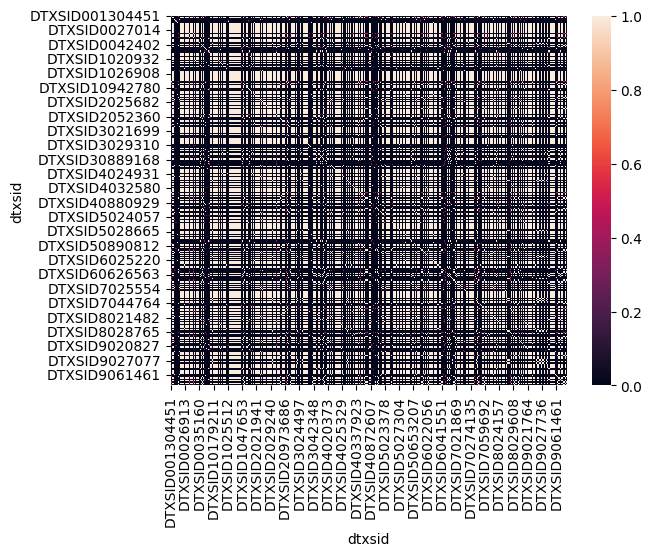

In [57]:
import seaborn as sns
sns.heatmap(S_react)

In [58]:
rax.head(1)

,Index,Substance Name in Assessment,substance_role,Approach,dtxsid,Preferred Name,CASRN,SMILES,QSAR Ready SMILES,analogue_evidence_stream,use_case,source
0,1,Chlorobenzene,Target,Category,DTXSID4020298,Chlorobenzene,108-90-7,ClC1=CC=CC=C1,ClC1=CC=CC=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study


In [59]:
mydict = {}
for i, group in rax.groupby('Index'):
    subset = list(group['dtxsid'])
    mydict[i] = subset

In [316]:
#mydict

In [326]:
#S_react

In [60]:
S_react.columns.name = None

In [61]:
S_react.index.name = None

In [404]:
S_react.to_csv(external_dir/'OECD_alerts_sim.csv')

In [62]:
mydict2 = {}
for k,v in mydict.items():
    common_indices = np.intersect1d(v, S_react.index)
    # Filter S_react using common indices
    a = S_react.loc[common_indices, common_indices]
    mk = np.triu(np.ones_like(a), k=1)
    b = a.where(mk == 1, np.nan).unstack().reset_index().dropna()
    b2 = b[b['level_0'] != b['level_1']]
    b3 = b2[0].to_numpy()
    mydict2[k] = b3

In [63]:
mydict[1]

['DTXSID4020298',
 'DTXSID1020431',
 'DTXSID6020430',
 'DTXSID6022056',
 'DTXSID0021965',
 'DTXSID8026193',
 'DTXSID8026195',
 'DTXSID1026089',
 'DTXSID6026088',
 'DTXSID7024320',
 'DTXSID7024247',
 'DTXSID2020682']

In [64]:
S_react.loc[mydict[1], mydict[1]]

,DTXSID4020298,DTXSID1020431,DTXSID6020430,DTXSID6022056,DTXSID0021965,DTXSID8026193,DTXSID8026195,DTXSID1026089,DTXSID6026088,DTXSID7024320,DTXSID7024247,DTXSID2020682
DTXSID4020298,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DTXSID1020431,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DTXSID6020430,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DTXSID6022056,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DTXSID0021965,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DTXSID8026193,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DTXSID8026195,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DTXSID1026089,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DTXSID6026088,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DTXSID7024320,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<Axes: >

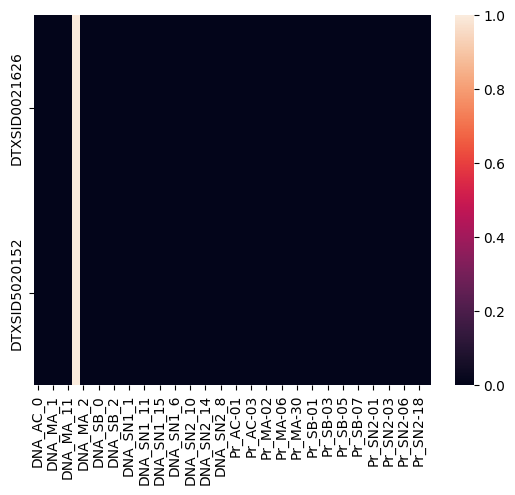

In [65]:
sns.heatmap(alerts_df[alerts_df.index.isin(mydict[101])])

/tmp/ipykernel_34473/4027442347.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=keys)


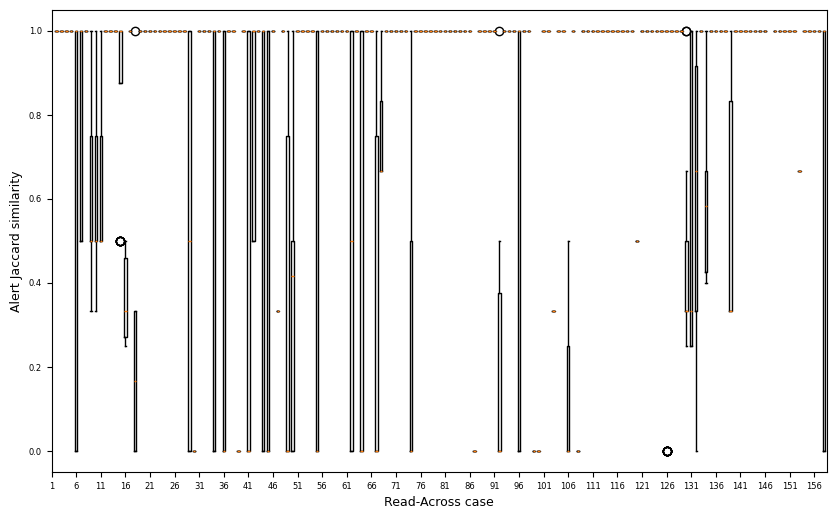

In [66]:
keys = list(mydict2.keys())
values = list(mydict2.values())

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(values, labels=keys)

n = 5  # Change this to set the interval of tick labels
selected_indices = range(0, len(keys), n)
selected_labels = [keys[i] for i in selected_indices]

# Set the selected tick positions and labels
plt.xticks(selected_indices, selected_labels, fontsize=6);

plt.xlabel('Read-Across case', fontsize=9)
plt.ylabel('Alert Jaccard similarity',fontsize=9)

plt.yticks(fontsize=6)
plt.savefig(figures_dir/'Alert_similarity.png', dpi = 300);  # Y-axis tick labels

In [355]:
alerts_df.head()

,DNA_AC_0,DNA_AC_9,DNA_MA_1,DNA_MA_10,DNA_MA_11,DNA_MA_12,DNA_MA_2,DNA_MA_9,DNA_SB_0,DNA_SB_1,...,Pr_SB-07,Pr_SB-08,Pr_SN2-01,Pr_SN2-02,Pr_SN2-03,Pr_SN2-05,Pr_SN2-06,Pr_SN2-07,Pr_SN2-18,Pr_SN2-23
DTXSID001304451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020151,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
DTXSID0020232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020440,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [358]:
rax_dict = {k:v for k,v  in zip(rax['dtxsid'], rax['Index'])}

In [361]:
alerts_df1 = (alerts_df
 
 .assign(group = lambda df:df.index.map(rax_dict))
)

<Axes: >

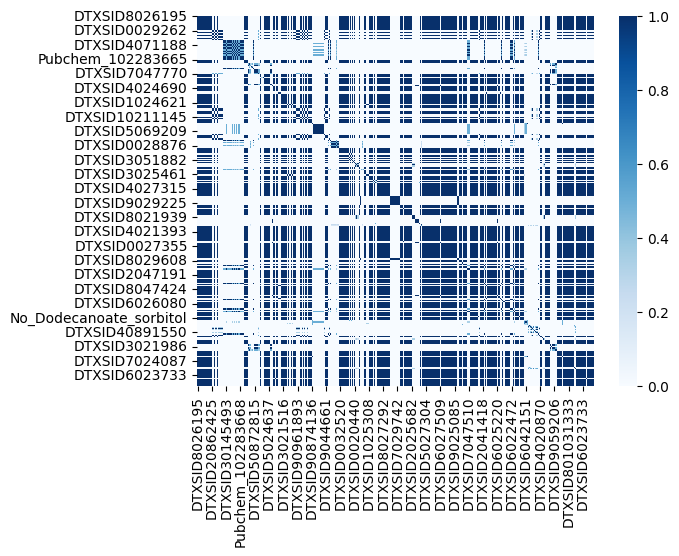

In [402]:
groups = [rax_dict.get(substance_id, None) for substance_id in S_react.index]

# Sort the indices based on the group number
sorted_indices = np.argsort(groups)  # Sort indices by the group number

# Reorder the similarity matrix based on sorted indices
sorted_matrix = S_react.iloc[sorted_indices, sorted_indices]


sns.heatmap(sorted_matrix, cmap='Blues', annot=False)

In [367]:
from pandas.plotting import parallel_coordinates

In [370]:
selected_groups = alerts_df1['group'].sample(20).unique()
alert_df_reduced = alerts_df1[alerts_df1['group'].isin(selected_groups)]

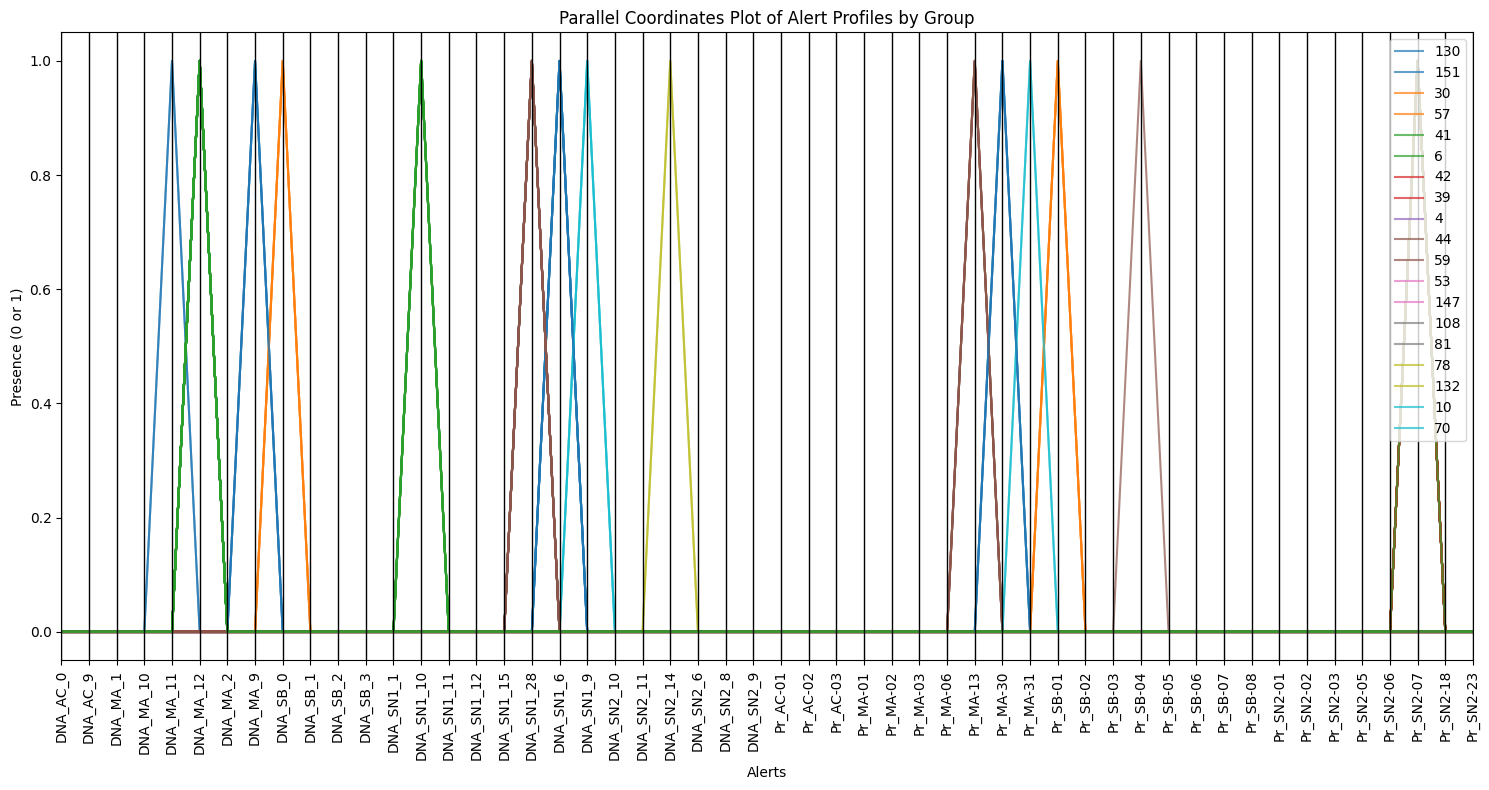

In [373]:
plt.figure(figsize=(15, 8))
parallel_coordinates(alert_df_reduced, class_column='group', colormap='tab10', alpha=0.7)

# Customize the plot
plt.title('Parallel Coordinates Plot of Alert Profiles by Group')
plt.xlabel('Alerts')
plt.ylabel('Presence (0 or 1)')
plt.xticks(rotation=90)  # Rotate x-axis for readability if needed
plt.grid(False)
plt.tight_layout()
plt.show()

In [374]:
import networkx as nx

In [390]:
# Initialize the graph
G = nx.Graph()

# Add nodes with group attributes
for substance, group in rax_dict.items():
    G.add_node(substance, group=group)

# Add edges based on a similarity threshold
threshold = 0.5
for i, substance1 in enumerate(S_react.index):
    for j, substance2 in enumerate(S_react.columns):
        if i < j:  # Avoid duplicates and self-loops
            similarity = S_react.iloc[i, j]
            if similarity > threshold:
                G.add_edge(substance1, substance2, weight=similarity)


Text(0.5, 1.0, 'Network Graph of Chemical Similarities')

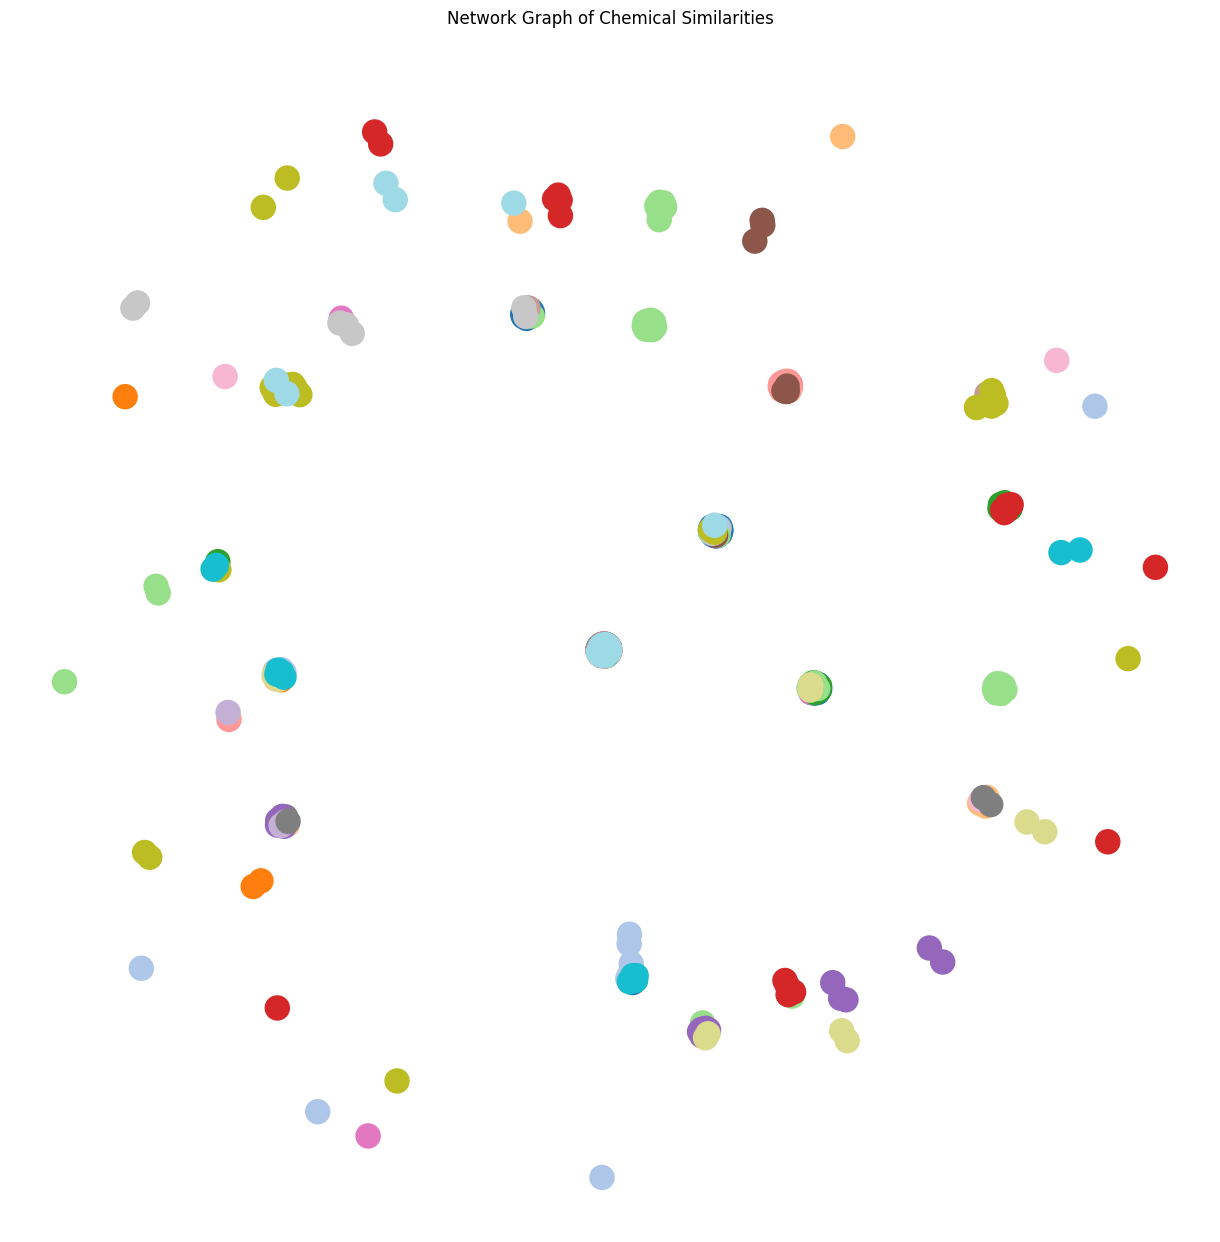

In [391]:
pos = nx.spring_layout(G)  # You can try other layouts, like `circular_layout` or `kamada_kawai_layout`

# Get node colors based on group
group_colors = {group: i for i, group in enumerate(set(rax_dict.values()))}
node_colors = [group_colors[G.nodes[node]['group']] for node in G.nodes]

# Draw the network
plt.figure(figsize=(12, 12))
nx.draw(
    G, pos,
    with_labels=False,
    node_color=node_colors,
    node_size=300,
    edge_color='gray',
    width=[G[u][v]['weight'] for u, v in G.edges],
    cmap=plt.cm.tab20
)

plt.title("Network Graph of Chemical Similarities")

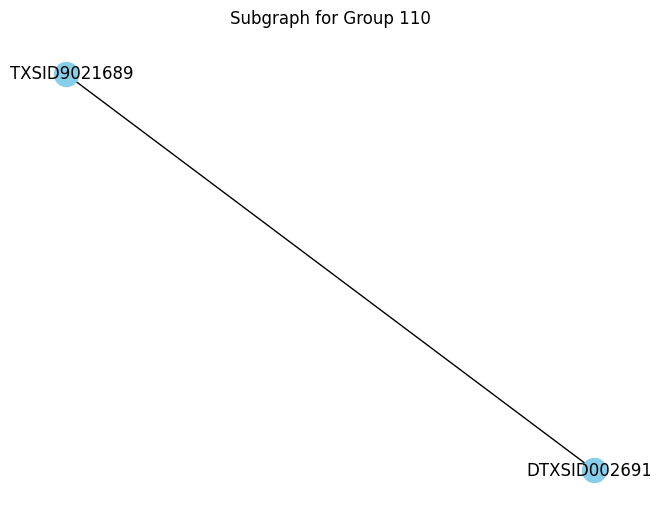

In [393]:
group_to_plot = 110
nodes_in_group = [n for n, attr in G.nodes(data=True) if attr['group'] == group_to_plot]
subgraph = G.subgraph(nodes_in_group)

nx.draw(subgraph, with_labels=True, node_size=300, node_color='skyblue')
plt.title(f"Subgraph for Group {group_to_plot}")
plt.show()

In [403]:
rax

,Index,Substance Name in Assessment,substance_role,Approach,dtxsid,Preferred Name,CASRN,SMILES,QSAR Ready SMILES,analogue_evidence_stream,use_case,source
0,1,Chlorobenzene,Target,Category,DTXSID4020298,Chlorobenzene,108-90-7,ClC1=CC=CC=C1,ClC1=CC=CC=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study
1,1,"1,4-Dichlorobenzene",Target,Category,DTXSID1020431,"1,4-Dichlorobenzene",106-46-7,ClC1=CC=C(Cl)C=C1,ClC1=CC=C(Cl)C=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study
2,1,"1,2-Dichlorobenzene",Category member,Category,DTXSID6020430,"1,2-Dichlorobenzene",95-50-1,ClC1=C(Cl)C=CC=C1,ClC1=C(Cl)C=CC=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study
3,1,"1,3-Dichlorobenzene",Target,Category,DTXSID6022056,"1,3-Dichlorobenzene",541-73-1,ClC1=CC(Cl)=CC=C1,ClC1=CC(Cl)=CC=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study
4,1,"1,2,4-Trichlorobenzene",Source Analogue,Category,DTXSID0021965,"1,2,4-Trichlorobenzene",120-82-1,ClC1=CC(Cl)=C(Cl)C=C1,ClC1=CC(Cl)=C(Cl)C=C1,Structural_ChemMine-tools_MCS-Tanimoto | Physc...,technical_guidance,OECD IATA case study
...,...,...,...,...,...,...,...,...,...,...,...,...
1014,157,Propiconazole,Category member,Category,DTXSID8024280,Propiconazole,60207-90-1,CCCC1COC(CN2C=NC=N2)(O1)C1=C(Cl)C=C(Cl)C=C1,CCCC1COC(CN2C=NC=N2)(O1)C1=C(Cl)C=C(Cl)C=C1,Structural_similar-scaffold_common-functional-...,NAMs,journal_article
1015,157,Prothioconazole,Category member,Category,DTXSID4034869,Prothioconazole,178928-70-6,OC(CN1N=CNC1=S)(CC1=C(Cl)C=CC=C1)C1(Cl)CC1,OC(CN1N=CNC1=S)(CC1=C(Cl)C=CC=C1)C1(Cl)CC1,Structural_similar-scaffold_common-functional-...,NAMs,journal_article
1016,157,Tebuconazole,Category member,Category,DTXSID9032113,Tebuconazole,107534-96-3,CC(C)(C)C(O)(CCC1=CC=C(Cl)C=C1)CN1C=NC=N1,CC(C)(C)C(O)(CCC1=CC=C(Cl)C=C1)CN1C=NC=N1,Structural_similar-scaffold_common-functional-...,NAMs,journal_article
1017,157,Triadimenol,Category member,Category,DTXSID0032493,Triadimenol,55219-65-3,CC(C)(C)C(O)C(OC1=CC=C(Cl)C=C1)N1C=NC=N1,CC(C)(C)C(O)C(OC1=CC=C(Cl)C=C1)N1C=NC=N1,Structural_similar-scaffold_common-functional-...,NAMs,journal_article
